In [15]:
## for thesis appendix

# Prepairing dataset for FMD+R

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from matplotlib import cm

# Load customer data into a Pandas DataFrame
df= pd.read_csv('/Users/mustansirmurtazakaj/Desktop/SBPC/Inputs/fmd+r 2022.csv', sep=';')

# Encode the product categories
df['product category'] = df['product category'].astype('category').cat.codes

# Calculate the recency
recency = df.groupby('customer')['recency'].min().reset_index()
recency.columns = ['customer', 'recency']

# Calculate the frequency
frequency = df.groupby('customer')['product'].count().reset_index()
frequency.columns = ['customer', 'frequency']

# Calculate the monetary value
monetary_value = df.groupby('customer')['price'].sum().reset_index()
monetary_value.columns = ['customer', 'monetary_value']

# Calculate the diversity
diversity = df.groupby('customer')['product'].nunique().reset_index()
diversity.columns = ['customer', 'diversity']

product_category = df.groupby('customer')['product category'].apply(lambda x: ','.join(set(x.astype(str)))).reset_index()
product_category.columns = ['customer', 'product category']

# Merge the columns into a single dataframe
rfmd = recency.merge(frequency, on='customer') \
        .merge(monetary_value, on='customer') \
        .merge(diversity, on='customer') \
        .merge(product_category, on='customer')

# Calculate the products
products = df.groupby('customer')['product'].apply(lambda x: ','.join(x)).reset_index()
products.columns = ['customer', 'products']

# Merge the new column into the final dataframe
rfmd = rfmd.merge(products, on='customer')

# Save the resulting dataframe to a csv file
rfmd.to_excel('/Users/mustansirmurtazakaj/Desktop/SBPC/Outputs/rfmd.xlsx', index=False)

## Pre-processing data

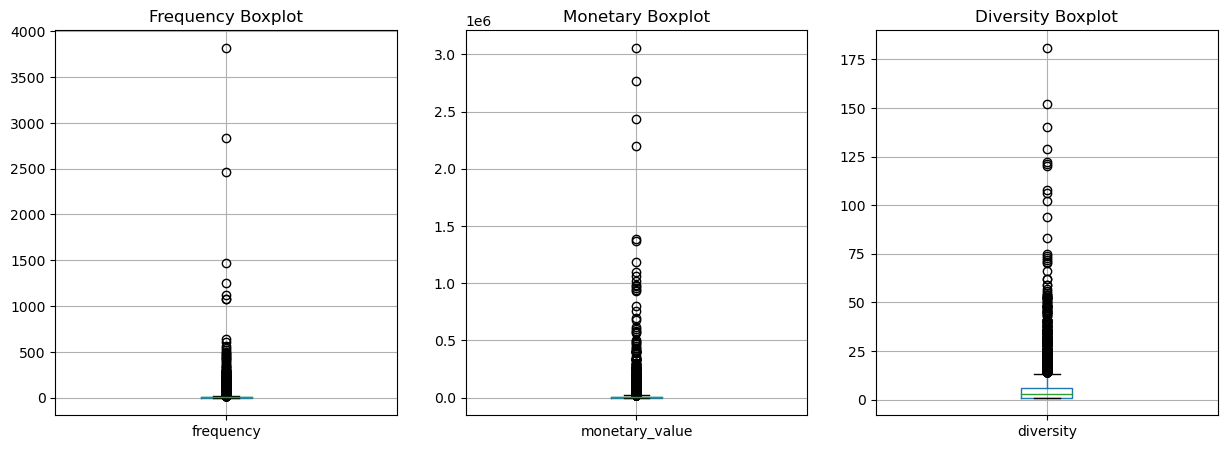

monetary ouliers: 379

frequency outliers: 186

diversity outliers: 0



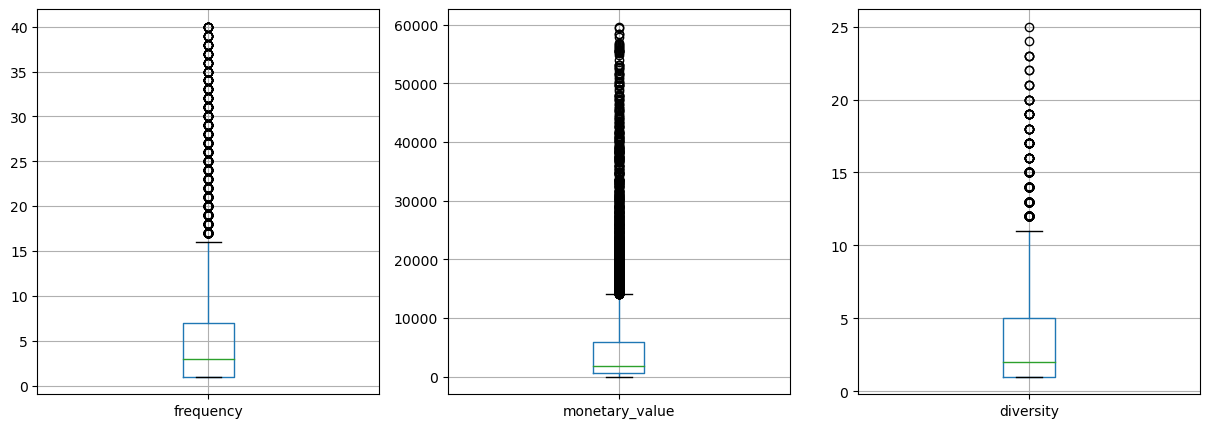

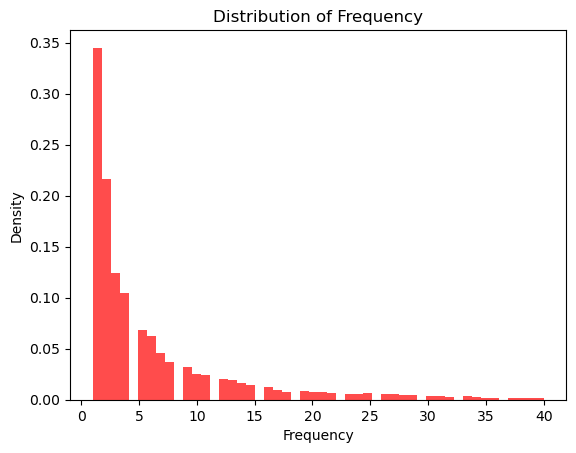

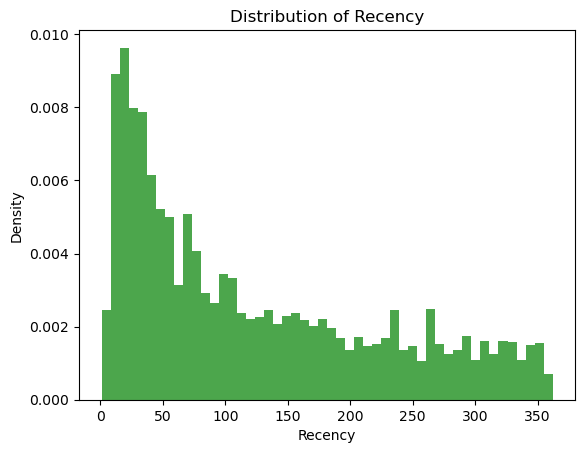

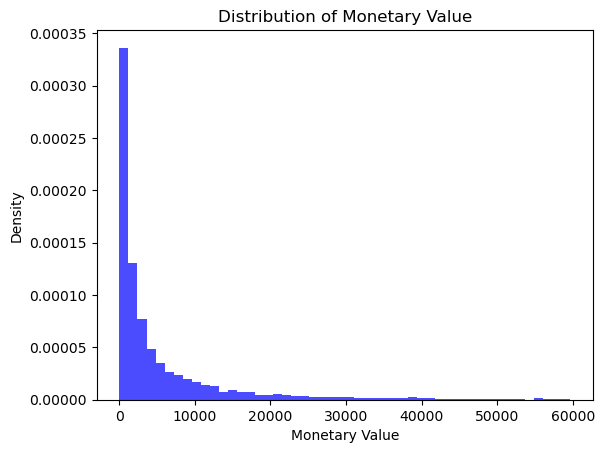

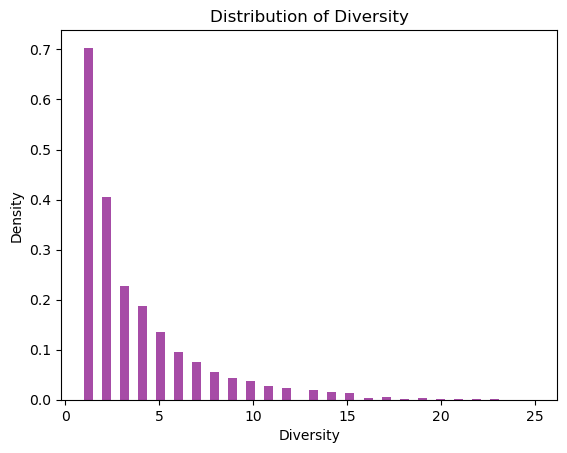

In [18]:
# Plot boxplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
rfmd.boxplot(column=['frequency'], ax=ax[0])
ax[0].set_title('Frequency Boxplot')
rfmd.boxplot(column=['monetary_value'], ax=ax[1])
ax[1].set_title('Monetary Boxplot')
rfmd.boxplot(column=['diversity'], ax=ax[2])
ax[2].set_title('Diversity Boxplot')
plt.show()

#Define a threshold to drop the outliers
threshold_monetary = 60000
threshold_frequency = 40
threshold_diversity = 25

#Remove the outliers in monetary column
rfmd_monetary_outliers = rfmd[rfmd['monetary_value'] > threshold_monetary]
rfmd = rfmd[rfmd['monetary_value'] <= threshold_monetary]

#Remove the outliers in freq column
rfmd_frequency_outliers = rfmd[rfmd['frequency'] > threshold_frequency]
rfmd = rfmd[rfmd['frequency'] <= threshold_frequency]

#Remove the outliers in diversity column
rfmd_diversity_outliers = rfmd[rfmd['diversity'] > threshold_diversity]
rfmd = rfmd[rfmd['diversity'] <= threshold_diversity]

keyaccounts_rfmd = pd.merge(rfmd_monetary_outliers, rfmd_frequency_outliers, on='customer')

#explode the products
rfmd_monetary_outliers = rfmd_monetary_outliers.set_index('customer')['products'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='products')

# Plot the outlier adjusted boxplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
rfmd.boxplot(column=['frequency'], ax=ax[0])
ax[0].set_title('')
rfmd.boxplot(column=['monetary_value'], ax=ax[1])
ax[1].set_title('')
rfmd.boxplot(column=['diversity'], ax=ax[2])
ax[2].set_title('')
plt.show()



## Applying FMD

In [19]:
# Setting percentile thresholds according to the company's deinitions  
quantiles = df_fmd.quantile(q=[0.04167, 0.0830, 0.167, 0.1, 0.125, 0.2, 0.25,0.33,0.4,0.5, 0.6, 0.65,0.75,0.85, 0.9,1.0])
quantiles

# Arguments (x = value, p = frequency, monetary_value, diversity, d = quartiles dict)
def FScore(x,p,d):
    if x <= 40*0.0625:
        return 1
    elif x <= 40*0.125:
        return 2
    elif x <= 40*0.25: 
        return 3
    else:
        return 4

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def MScore(x,p,d):
    if x <= 60000*0.04167:
        return 1
    elif x <= 60000*0.0830:
        return 2
    elif x <= 60000*0.167: 
        return 3
    else:
        return 4
      
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def DScore(x,p,d):
    if x <= 25*0.1:
        return 1
    elif x <= 25*0.125:
        return 2
    elif x <= 25*0.2: 
        return 3
    else:
        return 4
    
#create rfm segmentation table
fmd_segmentation = df_fmd

fmd_segmentation['F_Quartile'] = fmd_segmentation['frequency'].apply(FScore, args=('frequency',quantiles,))
fmd_segmentation['M_Quartile'] = fmd_segmentation['monetary_value'].apply(MScore, args=('monetary_value',quantiles,))
fmd_segmentation['D_Quartile'] = fmd_segmentation['diversity'].apply(DScore, args=('diversity',quantiles,))

#scoring
fmd_segmentation['FMDScore'] = fmd_segmentation.F_Quartile.map(str) \
                                + fmd_segmentation.M_Quartile.map(str) \
                                + fmd_segmentation.D_Quartile.map(str)

In [20]:
label_dict = {
   
    '444': 'high_value', 
    '443': 'high_value', 
    '442': 'high_value', 
    '434': 'high_value', 

    '213': 'diverse',
    '323': 'diverse',
    '223': 'diverse',
    '324': 'diverse',
    '334': 'diverse',
    
    '341': 'big_spender',
    '241': 'big_spender',
    '242': 'big_spender',
    '243': 'big_spender',
    '141': 'big_spender',

    '211': 'infrequent',
    '212': 'infrequent',
    '222': 'infrequent',
    '221': 'infrequent',
    '121': 'infrequent',
    
    '332': 'avg_spender',
    '333': 'avg_spender',
    
    '131': 'budget_concious',
    
    '111': 'new'
}

fmd_segmentation['label'] = fmd_segmentation['FMDScore'].map(label_dict)
    
#saving clusters in separate df(s)
high_value = fmd_segmentation[fmd_segmentation['label'] == 'high_value']
diverse = fmd_segmentation[fmd_segmentation['label'] == 'diverse']
big_spender = fmd_segmentation[fmd_segmentation['label'] == 'big_spender']
avg_spender = fmd_segmentation[fmd_segmentation['label'] == 'avg_spender']
infrequent = fmd_segmentation[fmd_segmentation['label'] == 'infrequent']
budget_concious = fmd_segmentation[fmd_segmentation['label'] == 'budget_concious']
new = fmd_segmentation[fmd_segmentation['label'] == 'new']

high_value:  1014
diverse:  750
big_spender:  152
infrequent:  1171
avg_spender:  168
budget_concious:  84
new:  2694


### FMD - threshold - silhouette - mark1

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

df_cluster_eval= fmd_segmentation
df_cluster_eval.dropna(subset=['label'], inplace=True)

# Iterate over each column 
for column in df_cluster_eval.columns:
    # Checkig if the data type of the column is non-numeric
    if df_cluster_eval[column].dtype == 'object':
        # Initializing LabelEncoder
        label_encoder = LabelEncoder()
        # Fit and transform the column to numeric values
        df_cluster_eval[column] = label_encoder.fit_transform(df_cluster_eval[column])
        
cluster_labels = df_cluster_eval['label']

# Preprocess the data by scaling the features_fmd_kmeans
scaler = StandardScaler()
df_cluster_eval = scaler.fit_transform(df_cluster_eval)

# Calculate the scores
silhouette_avgg = silhouette_score(df_cluster_eval, cluster_labels)
davies_bouldin_avgg = davies_bouldin_score(df_cluster_eval, cluster_labels)

The silhouette score of the clusters is: 0.15115691966644315
The calinski_harabasz score of the clusters is: 1520.6302171837733
The davies_bouldin score of the clusters is: 1.9650164496541156


### {RFM, FMD, FM} - Kmeans pre processing

In [22]:
df_rfmd_kmeans= pd.read_csv('/Users/mustansirmurtazakaj/Desktop/SBPC/Inputs/fmd_kmeans.csv', sep=';')

# Drop the column:
df_rfm_kmeans = df_rfmd_kmeans.drop('diversity', axis=1)
df_fmd_kmeans = df_rfmd_kmeans.drop('recency', axis=1)
df_fm_kmeans = df_fmd_kmeans.drop('diversity', axis=1)

# Select the features_fmd_kmeans (R, F, M) for clustering
features_rfm_kmeans = ['recency', 'frequency', 'monetary_value']
features_fmd_kmeans = ['frequency', 'monetary_value', 'diversity']
features_fm_kmeans = ['frequency', 'monetary_value']

# Preprocess the data by scaling the features_fmd_kmeans
scaler = StandardScaler()
df_rfm_kmeans_scaled = scaler.fit_transform(df_rfm_kmeans[features_rfm_kmeans])
df_fmd_kmeans_scaled = scaler.fit_transform(df_fmd_kmeans[features_fmd_kmeans])
df_fm_kmeans_scaled = scaler.fit_transform(df_fm_kmeans[features_fm_kmeans])

## elbow method [RFM]

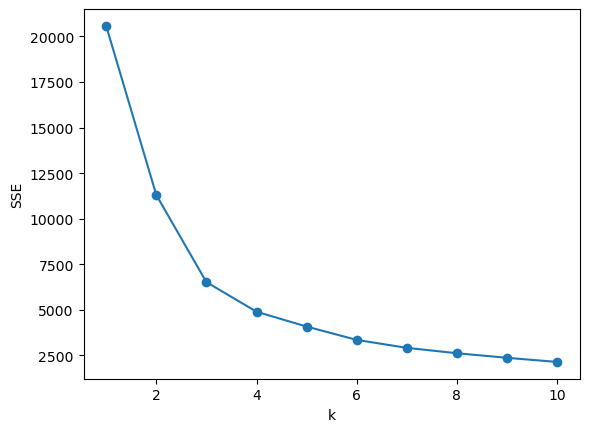

In [23]:
sse = []
k_values = range(1, 11)

# Perform K-means clustering for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_rfm_kmeans_scaled)
    sse.append(kmeans.sse)

plt.plot(k_values, sse, marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('')
plt.show()


## elbow method [FMD]

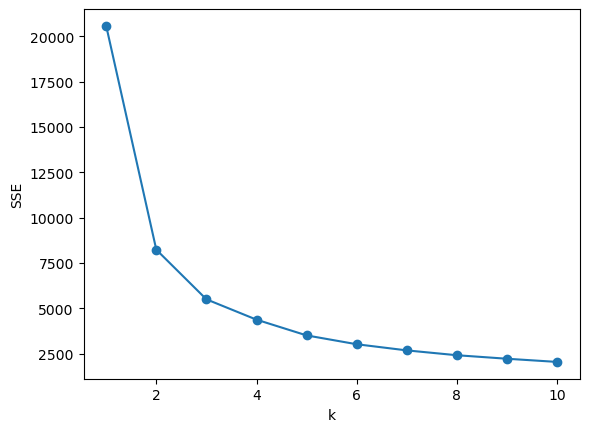

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Initialize an empty list to store the inertia (within-cluster sum of squares) values
inertia = []

# Define the range of number of clusters to evaluate
k_values = range(1, 11)

# Perform K-means clustering for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_fmd_kmeans_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('')
plt.show()


## elbow method [FM]

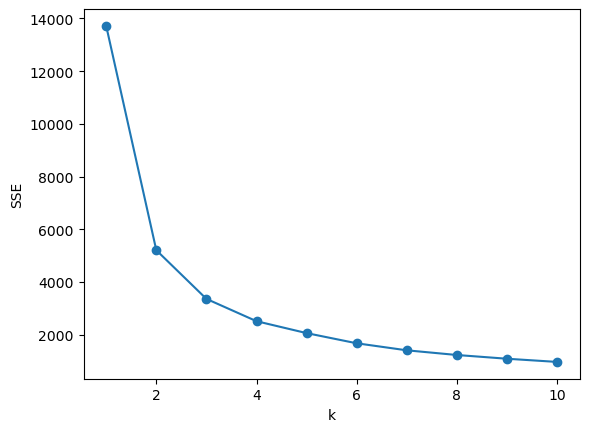

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming your df_fm_kmeans is stored in a variable named 'df_fm_kmeans'
# 'df_fm_kmeans' should be a 2D array or df_fm_kmeansFrame containing your RFM parameters

# Initialize an empty list to store the inertia (within-cluster sum of squares) values
inertia = []

# Define the range of number of clusters to evaluate
k_values = range(1, 11)

# Perform K-means clustering for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_fm_kmeans_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('')
plt.show()


## fitting model and plotting clusters

In [27]:
# Fit the k-means toscaled data
kmeans1 = KMeans(n_clusters=5, random_state=42)
kmeans2 = KMeans(n_clusters=5, random_state=42)
kmeans3 = KMeans(n_clusters=5, random_state=42)

kmeans1.fit(df_rfm_kmeans_scaled)
kmeans2.fit(df_fmd_kmeans_scaled)
kmeans3.fit(df_fm_kmeans_scaled)

cluster_labels1 = kmeans1.labels_
cluster_labels2 = kmeans2.labels_
cluster_labels3 = kmeans3.labels_

# Add labels to the original dataset
df_rfm_kmeans['Cluster'] = cluster_labels1
df_fmd_kmeans['Cluster'] = cluster_labels2
df_fm_kmeans['Cluster'] = cluster_labels3


RFM
Cluster 0: 3014 customers
Cluster 1: 1159 customers
Cluster 2: 2081 customers
Cluster 3: 370 customers
Cluster 4: 235 customers
FMD
Cluster 0: 4089 customers
Cluster 1: 625 customers
Cluster 2: 268 customers
Cluster 3: 176 customers
Cluster 4: 1701 customers
FM
Cluster 0: 1370 customers
Cluster 1: 166 customers
Cluster 2: 446 customers
Cluster 3: 4715 customers
Cluster 4: 162 customers


## Kmeans scatter plot for FMD

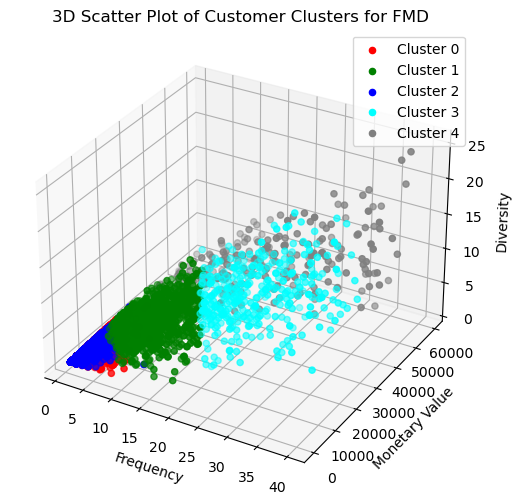

In [28]:
import matplotlib.pyplot as plt

# Initialize the 3D scatter plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points with different colors for each cluster
colors = ['red', 'green', 'blue', 'cyan', 'grey']
for i in range(5):
    cluster = df_fmd_kmeans[cluster_labels1 == i]
    ax.scatter( cluster['frequency'], cluster['monetary_value'], cluster['diversity'], c=colors[i], label='Cluster ' + str(i))

# Add labels and title to the plot
ax.set_zlabel('Diversity')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary Value')
ax.set_title('3D Scatter Plot of Customer Clusters for FMD')
plt.legend()

# Show the plot
plt.show()





## Kmeans scatter plot for RFM

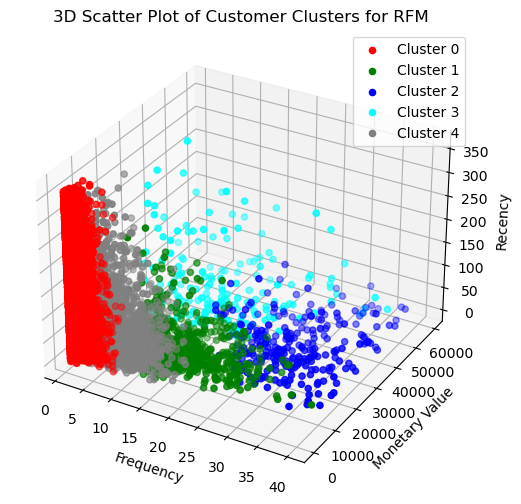

In [29]:

import matplotlib.pyplot as plt

# Initialize the 3D scatter plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points with different colors for each cluster
colors = ['red', 'green', 'blue', 'cyan', 'grey']
for i in range(5):
    cluster = df_rfm_kmeans[cluster_labels2 == i]
    ax.scatter( cluster['frequency'], cluster['monetary_value'], cluster['recency'], c=colors[i], label='Cluster ' + str(i))

# Add labels and title to the plot
ax.set_zlabel('Recency')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary Value')
ax.set_title('3D Scatter Plot of Customer Clusters for RFM')
plt.legend()

# Show the plot
plt.show()





## kmeans scatter plot for FM

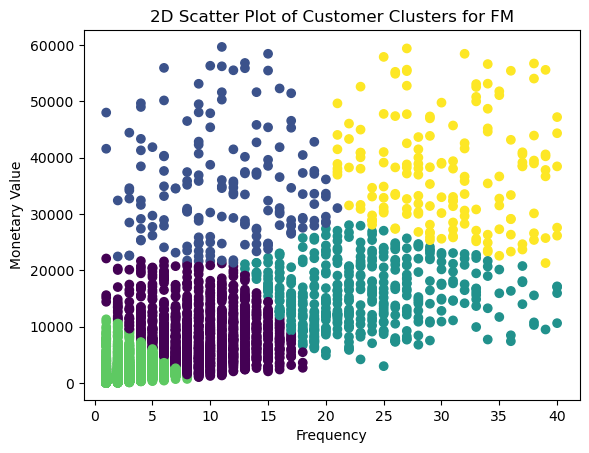

In [30]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(df_fm_kmeans['frequency'], df_fm_kmeans['monetary_value'], c=cluster_labels3)

# Add labels and title to the plot
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.title('2D Scatter Plot of Customer Clusters for FM')

# Show the plot
plt.show()

## Silhouete, calsinki and davies scoring

In [31]:
# Calculate the silhouette score
silhouette_avg_rfm = silhouette_score(df_rfm_kmeans_scaled, cluster_labels1)
silhouette_avg_fmd = silhouette_score(df_fmd_kmeans_scaled, cluster_labels2)
silhouette_avg_fm = silhouette_score(df_fm_kmeans_scaled, cluster_labels3)

# Calculate the davies_bouldin_index
davies_bouldin_index_rfm = davies_bouldin_score(df_rfm_kmeans_scaled, cluster_labels1)
davies_bouldin_index_fmd = davies_bouldin_score(df_fmd_kmeans_scaled, cluster_labels2)
davies_bouldin_index_fm = davies_bouldin_score(df_fm_kmeans_scaled, cluster_labels3)

rfm - The silhouette score of the clusters is: 0.44411542487259015
fmd - The silhouette score of the clusters is: 0.5307177110604359
fm - The silhouette score of the clusters is: 0.5973772231612998
rfm - Davies-Bouldin index: 0.9131151287257078
fmd - Davies-Bouldin index: 0.8737827717578508
fm - Davies-Bouldin index: 0.7971978519807378
rfm - calinski_harabasz_index: 6920.827395963312
fmd - calinski_harabasz_index: 8362.191217545342
fm - calinski_harabasz_index: 9696.162287767484



## Applying RFM (nishan)

In [ ]:
# Setting percentile thresholds
quantiles_rfm = df_rfm.quantile(q=[0.04167, 0.0830, 0.167, 0.1, 0.125, 0.2, 0.25,0.33,0.4,0.5, 0.6, 0.65,0.75,0.85, 0.9,1.0])

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FScore(x,p,d):
    if x <= d[p][0.125]:
        return 1
    elif x <= d[p][0.25]:
        return 2
    elif x <= d[p][0.50]: 
        return 3
    else:
        return 4

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def MScore(x,p,d):
    if x <= d[p][0.04167]:
        return 1
    elif x <= d[p][0.0830]:
        return 2
    elif x <= d[p][0.167]: 
        return 3
    else:
        return 4
      
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
#create rfm segmentation table
rfm_segmentation = df_rfm

rfm_segmentation['R_Quartile'] = rfm_segmentation['recency'].apply(RScore, args=('recency',quantiles_rfm,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['frequency'].apply(FScore, args=('frequency',quantiles_rfm,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['monetary_value'].apply(MScore, args=('monetary_value',quantiles_rfm,))



#scoring
rfm_segmentation['FMRScore'] = rfm_segmentation.F_Quartile.map(str) \
                                + rfm_segmentation.M_Quartile.map(str) \
                                + rfm_segmentation.R_Quartile.map(str)


In [ ]:
#declare all customer segments
print("high_value: ",len(rfm_segmentation[rfm_segmentation['FMRScore']=='444'])
      +len(rfm_segmentation[rfm_segmentation['FMRScore']=='443'])
      +len(rfm_segmentation[rfm_segmentation['FMRScore']=='442']))

print('big_spender: ',len(rfm_segmentation[rfm_segmentation['FMRScore']=='341'])
+len(rfm_segmentation[rfm_segmentation['FMRScore']=='342'])
+len(rfm_segmentation[rfm_segmentation['FMRScore']=='343']))

print('infrequent: ',len(rfm_segmentation[rfm_segmentation['FMRScore']=='131'])
+len(rfm_segmentation[rfm_segmentation['FMRScore']=='211'])
+len(rfm_segmentation[rfm_segmentation['FMRScore']=='111']))

print('avg_spender: ',len(rfm_segmentation[rfm_segmentation['FMRScore']=='331'])
+len(rfm_segmentation[rfm_segmentation['FMRScore']=='332']))

print('budget_concious: ',len(rfm_segmentation[rfm_segmentation['FMRScore']=='131']))

print('new: ',len(rfm_segmentation[rfm_segmentation['FMRScore']=='121']))


label_dict_rfm = {
   
    '444': 'high_value', 
    '443': 'high_value', 
    '442': 'high_value', 
    
    '341': 'big_spender',
    '342': 'big_spender',
    '343': 'big_spender',
    
    '131': 'infrequent',
    '211': 'infrequent',
    '111': 'infrequent',
    
    '331': 'avg_spender',
    '332': 'avg_spender',
    
    '131': 'budget_concious',
    
    '121': 'new', 
}

rfm_segmentation['label'] = rfm_segmentation['FMRScore'].map(label_dict_rfm)


#saving the data
rfm_segmentation.to_excel('/Users/mustansirmurtazakaj/Desktop/SBPC/Outputs/rfm_out_2022(2)excel.xlsx')  

#saving clusters in separate df(s)
high_value_rfm = rfm_segmentation[rfm_segmentation['label'] == 'high_value']
big_spender_rfm = rfm_segmentation[rfm_segmentation['label'] == 'big_spender']
avg_spender_rfm = rfm_segmentation[rfm_segmentation['label'] == 'avg_spender']
infrequent_rfm = rfm_segmentation[rfm_segmentation['label'] == 'infrequent']
budget_concious_rfm = rfm_segmentation[rfm_segmentation['label'] == 'budget_concious']
new_rfm = rfm_segmentation[rfm_segmentation['label'] == 'new']

# save the data to csv files
high_value_rfm.to_csv("/Users/mustansirmurtazakaj/Desktop/SBPC/Outputs/clusters/high_value_rfm.csv", index=False)
big_spender_rfm.to_csv("/Users/mustansirmurtazakaj/Desktop/SBPC/Outputs/clusters/big_spender_rfm.csv", index=False)
avg_spender_rfm.to_csv("/Users/mustansirmurtazakaj/Desktop/SBPC/Outputs/clusters/avg_spender_rfm.csv", index=False)
infrequent_rfm.to_csv("/Users/mustansirmurtazakaj/Desktop/SBPC/Outputs/clusters/infrequent_rfm.csv", index=False)
budget_concious_rfm.to_csv("/Users/mustansirmurtazakaj/Desktop/SBPC/Outputs/clusters/budget_concious_rfm.csv", index=False)
new_rfm.to_csv("new_rfm.csv", index=False)


## Prepairing data for recommendation models mark2

In [6]:
# drop duplicate rows based on the customer column
outliers.drop_duplicates(subset='customer', inplace=True)
outliers.to_excel('/Users/mustansirmurtazakaj/Desktop/SBPC/Outputs/outliers_FMD+R.xlsx')

# Exploding the 'products' column into separate rows
high_val_explode = high_value.set_index('customer')['products'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='products')
big_spender_explode = big_spender.set_index('customer')['products'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='products')

# Drop all other columns except 'customers' and 'products'
high_val_explode = high_val_explode[['customer', 'products']]
big_spender_explode = big_spender_explode[['customer', 'products']]

In [36]:
import turicreate as tc
from turicreate import SFrame

# Split the 'products' column into separate rows
diverse = diverse.assign(products=diverse.products.str.split(',')).explode('products')
high_value = high_value.assign(products=high_value.products.str.split(',')).explode('products')
big_spender = big_spender.assign(products=big_spender.products.str.split(',')).explode('products')
avg_spender = avg_spender.assign(products=avg_spender.products.str.split(',')).explode('products')
infrequent = infrequent.assign(products=infrequent.products.str.split(',')).explode('products')
budget_concious = budget_concious.assign(products=budget_concious.products.str.split(',')).explode('products')
new = new.assign(products=new.products.str.split(',')).explode('products')
fmd_segmentation = fmd_segmentation.assign(products=fmd_segmentation.products.str.split(',')).explode('products')
outliers = outliers.assign(products=outliers.products.str.split(',')).explode('products')

# Remove blank rows
diverse = diverse[diverse['products'].str.strip() != '']
high_value = high_value[high_value['products'].str.strip() != '']
big_spender = big_spender[big_spender['products'].str.strip() != '']
avg_spender = avg_spender[avg_spender['products'].str.strip() != '']
infrequent = infrequent[infrequent['products'].str.strip() != '']
budget_concious = budget_concious[budget_concious['products'].str.strip() != '']
new = new[new['products'].str.strip() != '']
fmd_segmentation = fmd_segmentation[fmd_segmentation['products'].str.strip() != '']
outliers = outliers[outliers['products'].str.strip() != '']

# convert df into sf
div_sf=tc.SFrame(diverse)
hival_sf=tc.SFrame(high_value)
bspen_sf=tc.SFrame(big_spender)
aspen_sf=tc.SFrame(avg_spender)
inf_sf=tc.SFrame(infrequent)
bcon_sf=tc.SFrame(budget_concious)
new_sf=tc.SFrame(new)

outliers = outliers.applymap(str)
outliers_sf=tc.SFrame(outliers)

rfmdc_pre_processed = fmd_segmentation.applymap(str)
preprocessed_sf=tc.SFrame(rfmdc_pre_processed)

#rename columns 
div_sf=div_sf.rename({'customer': 'user_id', 'products':'item_id'})
preprocessed_sf=preprocessed_sf.rename({'customer': 'user_id', 'products':'item_id'})
aspen_sf=aspen_sf.rename({'customer': 'user_id', 'products':'item_id'})
hival_sf=hival_sf.rename({'customer': 'user_id', 'products':'item_id'})
bspen_sf=bspen_sf.rename({'customer': 'user_id', 'products':'item_id'})
inf_sf=inf_sf.rename({'customer': 'user_id', 'products':'item_id'})
bcon_sf=bcon_sf.rename({'customer': 'user_id', 'products':'item_id'})
new_sf=new_sf.rename({'customer': 'user_id', 'products':'item_id'})
outliers_sf=outliers_sf.rename({'customer': 'user_id', 'products':'item_id'})

#separate training and testing datasets
div_sf_train, div_sf_test = tc.recommender.util.random_split_by_user(div_sf)
aspen_sf_train, aspen_sf_test = tc.recommender.util.random_split_by_user(aspen_sf)
preprocessed_sf_train, preprocessed_sf_test = tc.recommender.util.random_split_by_user(preprocessed_sf)
inf_sf_train, inf_sf_test = tc.recommender.util.random_split_by_user(inf_sf)
bcon_sf_train, bcon_sf_test = tc.recommender.util.random_split_by_user(bcon_sf)
new_sf_train, new_sf_test = tc.recommender.util.random_split_by_user(new_sf)
outliers_sf_train, outliers_sf_test = tc.recommender.util.random_split_by_user(outliers_sf)


## Cluster tailored recommendations: FMD+R

### Content based model

In [47]:
item_data= pd.read_csv('/Users/mustansirmurtazakaj/Desktop/PIM data/pim data final 2.csv', sep=';')
obs_data=pd.read_csv('/Users/mustansirmurtazakaj/Desktop/SBPC/Outputs/high_val_explode1.csv', sep=';')
obs_data_bigspender=pd.read_csv('/Users/mustansirmurtazakaj/Desktop/SBPC/Outputs/big_spender_explode1.csv', sep=';')

obs_data = obs_data.rename(columns={'products': 'item_id'})
obs_data = obs_data.rename(columns={'customer': 'user_id'})

obs_data_bigspender = obs_data_bigspender.rename(columns={'products': 'item_id'})
obs_data_bigspender = obs_data_bigspender.rename(columns={'customer': 'user_id'})

item_data = item_data.applymap(str)
obs_data_bigspender = obs_data_bigspender.applymap(str)
obs_data = obs_data.applymap(str)

item_data_sf=tc.SFrame(item_data) #pim data
obs_data_sf=tc.SFrame(obs_data) #sales data high value
obs_data_bigspender_sf=tc.SFrame(obs_data_bigspender) #sales data big spender

#separate train and test data
obs_data_sf_train, obs_data_sf_test = tc.recommender.util.random_split_by_user(obs_data_sf)
obs_data_bigspender_sf_train, obs_data_bigspender_sf_test = tc.recommender.util.random_split_by_user(obs_data_bigspender_sf)

model_hv=tc.recommender.item_content_recommender.create(item_data_sf, item_id='item_id', observation_data=obs_data_sf_train, user_id='user_id', target=None, weights='auto', similarity_metrics='cosine', item_data_transform='auto', max_item_neighborhood_size=64, verbose=True)
model_bs=tc.recommender.item_content_recommender.create(item_data_sf, item_id='item_id', observation_data=obs_data_bigspender_sf_train, user_id='user_id', target=None, weights='auto', similarity_metrics='cosine', item_data_transform='auto', max_item_neighborhood_size=64, verbose=True)
preprocessed_model_content=tc.recommender.item_content_recommender.create(item_data_sf, item_id='item_id', observation_data=preprocessed_sf_train, user_id='user_id', target=None, weights='auto', similarity_metrics='cosine', item_data_transform='auto', max_item_neighborhood_size=64, verbose=True)

rmodel_hv=model_hv.recommend(users=None, k=5, exclude=None, items=None, new_observation_data=None, new_user_data=None, new_item_data=None, exclude_known=True, diversity=5, random_seed=1, verbose=True)
rmodel_hv = pd.DataFrame(rmodel_hv)
rmodel_bs=model_bs.recommend(users=None, k=5, exclude=None, items=None, new_observation_data=None, new_user_data=None, new_item_data=None, exclude_known=True, diversity=5, random_seed=1, verbose=True)
rmodel_bs = pd.DataFrame(rmodel_bs)

rpreprocessed_model_content=preprocessed_model_content.recommend(users=None, k=5, exclude=None, items=None, new_observation_data=None, new_user_data=None, new_item_data=None, exclude_known=True, diversity=5, random_seed=1, verbose=True)
rpreprocessed_model_content = pd.DataFrame(rpreprocessed_model_content)

Applying transform:
Class             : AutoVectorizer

Model Fields
------------
Features          : ['data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9', 'data_10', 'data_11', 'data_12', 'data_13', 'data_14', 'data_15', 'data_16', 'data_17', 'data_18', 'data_19', 'data_20', 'data_21']
Excluded Features : ['item_id']

Column   Type  Interpretation  Transforms  Output Type
-------  ----  --------------  ----------  -----------
data_1   str   categorical     None        str        
data_2   str   categorical     None        str        
data_3   str   categorical     None        str        
data_4   str   categorical     None        str        
data_5   str   categorical     None        str        
data_6   str   categorical     None        str        
data_7   str   categorical     None        str        
data_8   str   categorical     None        str        
data_9   str   categorical     None        str        
data_10  str   categorical     None  

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1            | 9295    | 0.0107585   | 16.124ms     |

| 5699         | 5.3e+07 | 61.3125     | 3.03s        |

| Done         |         | 100         | 4.94s        |

+--------------+---------+-------------+--------------+

Warning: Ignoring columns Unnamed: 0;

To use one of these as a rating column, specify the column name to be used as target

and use a method that allows the use of a target.

Preparing data set.

Data has 17221 observations with 1014 users and 6928 items.

Data prepared in: 0.416076s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.019028s

Applying transform:
Class             : AutoVectorizer

Model Fields
------------
Features          : ['data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9', 'data_10', 'data_11', 'data_12', 'data_13', 'data_14', 'data_15', 'data_16', 'data_17', 'data_18', 'data_19', 'data_20', 'data_21']
Excluded Features : ['item_id']

Column   Type  Interpretation  Transforms  Output Type
-------  ----  --------------  ----------  -----------
data_1   str   categorical     None        str        
data_2   str   categorical     None        str        
data_3   str   categorical     None        str        
data_4   str   categorical     None        str        
data_5   str   categorical     None        str        
data_6   str   categorical     None        str        
data_7   str   categorical     None        str        
data_8   str   categorical     None        str        
data_9   str   categorical     None        str        
data_10  str   categorical     None  

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1            | 9295    | 0.0107585   | 11.463ms     |

| 6122         | 5.7e+07 | 65.8634     | 3.02s        |

| Done         |         | 100         | 4.62s        |

+--------------+---------+-------------+--------------+

Preparing data set.

Data has 521 observations with 150 users and 6727 items.

Data prepared in: 0.369s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.013547s

Applying transform:
Class             : AutoVectorizer

Model Fields
------------
Features          : ['data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9', 'data_10', 'data_11', 'data_12', 'data_13', 'data_14', 'data_15', 'data_16', 'data_17', 'data_18', 'data_19', 'data_20', 'data_21']
Excluded Features : ['item_id']

Column   Type  Interpretation  Transforms  Output Type
-------  ----  --------------  ----------  -----------
data_1   str   categorical     None        str        
data_2   str   categorical     None        str        
data_3   str   categorical     None        str        
data_4   str   categorical     None        str        
data_5   str   categorical     None        str        
data_6   str   categorical     None        str        
data_7   str   categorical     None        str        
data_8   str   categorical     None        str        
data_9   str   categorical     None        str        
data_10  str   categorical     None  

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1            | 9295    | 0.0107585   | 12.753ms     |

| 6043         | 5.6e+07 | 65.0134     | 3.02s        |

| Done         |         | 100         | 4.73s        |

+--------------+---------+-------------+--------------+

Warning: Ignoring columns recency, frequency, monetary_value, diversity, product category, F_Quartile, M_Quartile, D_Quartile, FMDScore, label;

To use one of these as a rating column, specify the column name to be used as target

and use a method that allows the use of a target.

Preparing data set.

Data has 41103 observations with 6799 users and 6981 items.

Data prepared in: 0.405655s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.015892s

recommendations finished on 1000/1014 queries. users per second: 82733.5

recommendations finished on 1000/6799 queries. users per second: 77567.5

recommendations finished on 2000/6799 queries. users per second: 79497.6

recommendations finished on 3000/6799 queries. users per second: 80083.3

recommendations finished on 4000/6799 queries. users per second: 80440.8

recommendations finished on 5000/6799 queries. users per second: 79373.9

recommendations finished on 6000/6799 queries. users per second: 78580.3

### Other models

In [49]:
# Modeling

## User similarity
div_model=tc.recommender.item_similarity_recommender.create(div_sf_train, user_id='user_id', item_id='item_id', target=None, user_data=None, item_data=None, nearest_items=None, similarity_type='jaccard', threshold=0.001, only_top_k=64, verbose=True, target_memory_usage=8589934592)
aspen_model=tc.recommender.item_similarity_recommender.create(aspen_sf_train, user_id='user_id', item_id='item_id', target=None, user_data=None, item_data=None, nearest_items=None, similarity_type='jaccard', threshold=0.001, only_top_k=64, verbose=True, target_memory_usage=8589934592)
bcon_model=tc.recommender.item_similarity_recommender.create(bcon_sf_train, user_id='user_id', item_id='item_id', target=None, user_data=None, item_data=None, nearest_items=None, similarity_type='jaccard', threshold=0.001, only_top_k=64, verbose=True, target_memory_usage=8589934592)
outliers_model=tc.recommender.item_similarity_recommender.create(outliers_sf_train, user_id='user_id', item_id='item_id', target=None, user_data=None, item_data=None, nearest_items=None, similarity_type='jaccard', threshold=0.001, only_top_k=64, verbose=True, target_memory_usage=8589934592)
preprocessed_model_cf=tc.recommender.item_similarity_recommender.create(preprocessed_sf_train, user_id='user_id', item_id='item_id', target=None, user_data=None, item_data=None, nearest_items=None, similarity_type='jaccard', threshold=0.001, only_top_k=64, verbose=True, target_memory_usage=8589934592)


## Popularity
new_model=tc.recommender.popularity_recommender.create(new_sf_train, user_id='user_id', item_id='item_id', target=None, user_data=None, item_data=None, random_seed=0, verbose=True)
inf_model=tc.recommender.popularity_recommender.create(inf_sf_train, user_id='user_id', item_id='item_id', target=None, user_data=None, item_data=None, random_seed=0, verbose=True)
preprocessed_model_pop=tc.recommender.popularity_recommender.create(preprocessed_sf_train, user_id='user_id', item_id='item_id', target=None, user_data=None, item_data=None, random_seed=0, verbose=True)

# Recommendations
div_recom = div_model.recommend(users=None, k=5, exclude=None, items=None, new_observation_data=None, new_user_data=None, new_item_data=None, exclude_known=True, diversity=0, random_seed=None, verbose=True)
aspen_recom = aspen_model.recommend(users=None, k=5, exclude=None, items=None, new_observation_data=None, new_user_data=None, new_item_data=None, exclude_known=True, diversity=0, random_seed=None, verbose=True)
bcon_recom = bcon_model.recommend(users=None, k=5, exclude=None, items=None, new_observation_data=None, new_user_data=None, new_item_data=None, exclude_known=True, diversity=0, random_seed=None, verbose=True)
new_recom=new_model.recommend(users=None, k=5, exclude=None, items=None, new_observation_data=None, new_user_data=None, new_item_data=None, exclude_known=True, diversity=0, random_seed=None, verbose=True)
inf_recom=inf_model.recommend(users=None, k=5, exclude=None, items=None, new_observation_data=None, new_user_data=None, new_item_data=None, exclude_known=True, diversity=0, random_seed=None, verbose=True)
preprocessed_recom_cf=preprocessed_model_cf.recommend(users=None, k=5, exclude=None, items=None, new_observation_data=None, new_user_data=None, new_item_data=None, exclude_known=True, diversity=0, random_seed=None, verbose=True)
preprocessed_recom_pop=preprocessed_model_pop.recommend(users=None, k=5, exclude=None, items=None, new_observation_data=None, new_user_data=None, new_item_data=None, exclude_known=True, diversity=0, random_seed=None, verbose=True)
outliers_recom=outliers_model.recommend(users=None, k=5, exclude=None, items=None, new_observation_data=None, new_user_data=None, new_item_data=None, exclude_known=True, diversity=0, random_seed=None, verbose=True)

# converting sf back to df
div_df = pd.DataFrame(div_recom)
aspen_df = pd.DataFrame(aspen_recom)
bcon_df = pd.DataFrame(bcon_recom)
new_df = pd.DataFrame(new_recom)
inf_df = pd.DataFrame(inf_recom)
preprocessed_df_cf = pd.DataFrame(preprocessed_recom)
preprocessed_df_pop = pd.DataFrame(preprocessed_recom)
outliers_df = pd.DataFrame(outliers_recom)

Warning: Ignoring columns recency, frequency, monetary_value, diversity, product category, F_Quartile, M_Quartile, D_Quartile, FMDScore, label;

To use one of these as a rating column, specify the column name to be used as target

and use a method that allows the use of a target.

Preparing data set.

Data has 3929 observations with 750 users and 255 items.

Data prepared in: 0.016348s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.184ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.86ms                              | 0                | 0               |

| 3.391ms                             | 100              | 255             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.006565s

Warning: Ignoring columns recency, frequency, monetary_value, diversity, product category, F_Quartile, M_Quartile, D_Quartile, FMDScore, label;

To use one of these as a rating column, specify the column name to be used as target

and use a method that allows the use of a target.

Preparing data set.

Data has 1054 observations with 168 users and 173 items.

Data prepared in: 0.005818s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.08ms                         | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.456ms                             | 0                | 0               |

| 2.844ms                             | 100              | 173             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.003942s

Warning: Ignoring columns recency, frequency, monetary_value, diversity, product category, F_Quartile, M_Quartile, D_Quartile, FMDScore, label;

To use one of these as a rating column, specify the column name to be used as target

and use a method that allows the use of a target.

Preparing data set.

Data has 117 observations with 79 users and 64 items.

Data prepared in: 0.002759s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.567ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.875ms                             | 0.5              | 0               |

| 2.498ms                             | 100              | 64              |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.002975s

Warning: Ignoring columns recency, frequency, monetary_value, diversity, product category;

To use one of these as a rating column, specify the column name to be used as target

and use a method that allows the use of a target.

Preparing data set.

Data has 9468 observations with 490 users and 279 items.

Data prepared in: 0.01458s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 631us                          | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 988us                               | 0.75             | 2               |

| 3.184ms                             | 100              | 279             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.007188s

Warning: Ignoring columns recency, frequency, monetary_value, diversity, product category, F_Quartile, M_Quartile, D_Quartile, FMDScore, label;

To use one of these as a rating column, specify the column name to be used as target

and use a method that allows the use of a target.

Preparing data set.

Data has 41103 observations with 6799 users and 400 items.

Data prepared in: 0.043375s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 700us                          | 14.5       |

| 1.932ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.302ms                             | 0                | 0               |

| 4.663ms                             | 100              | 400             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.007759s

Warning: Ignoring columns recency, frequency, monetary_value, diversity, product category, F_Quartile, M_Quartile, D_Quartile, FMDScore, label;

To use one of these as a rating column, specify the column name to be used as target

and use a method that allows the use of a target.

Preparing data set.

Data has 3490 observations with 2564 users and 251 items.

Data prepared in: 0.008539s

3490 observations to process; with 251 unique items.

Warning: Ignoring columns recency, frequency, monetary_value, diversity, product category, F_Quartile, M_Quartile, D_Quartile, FMDScore, label;

To use one of these as a rating column, specify the column name to be used as target

and use a method that allows the use of a target.

Preparing data set.

Data has 3190 observations with 1158 users and 245 items.

Data prepared in: 0.006671s

3190 observations to process; with 245 unique items.

Warning: Ignoring columns recency, frequency, monetary_value, diversity, product category, F_Quartile, M_Quartile, D_Quartile, FMDScore, label;

To use one of these as a rating column, specify the column name to be used as target

and use a method that allows the use of a target.

Preparing data set.

Data has 41103 observations with 6799 users and 400 items.

Data prepared in: 0.056091s

41103 observations to process; with 400 unique items.

recommendations finished on 1000/2564 queries. users per second: 759878

recommendations finished on 2000/2564 queries. users per second: 847458

recommendations finished on 1000/1158 queries. users per second: 853242

recommendations finished on 1000/6799 queries. users per second: 464900

recommendations finished on 2000/6799 queries. users per second: 468604

recommendations finished on 3000/6799 queries. users per second: 534378

recommendations finished on 4000/6799 queries. users per second: 570695

recommendations finished on 5000/6799 queries. users per second: 600024

recommendations finished on 6000/6799 queries. users per second: 616840

recommendations finished on 1000/6799 queries. users per second: 722022

recommendations finished on 2000/6799 queries. users per second: 816993

recommendations finished on 3000/6799 queries. users per second: 863309

recommendations finished on 4000/6799 queries. users per second: 891067

recommendations finished on 5000/6799 queries. users per second: 892061

recommendations finished on 6000/6799 queries. users per second: 921517

## Evaluation of recommendations

In [53]:
#mark3
eval_div = div_model.evaluate(div_sf_test)
eval_aspen = aspen_model.evaluate(aspen_sf_test)
eval_bcon = bcon_model.evaluate(bcon_sf_test)
eval_inf = inf_model.evaluate(inf_sf_test)
eval_new = new_model.evaluate(new_sf_test)
eval_hival = model_hv.evaluate(obs_data_sf_test)
eval_bspen = model_bs.evaluate(obs_data_bigspender_sf_test)
eval_preprocessed_pop = preprocessed_model_pop.evaluate(preprocessed_sf_test)
eval_preprocessed_cf = preprocessed_model_cf.evaluate(preprocessed_sf_test)
eval_preprocessed_content = preprocessed_model_content.evaluate(preprocessed_sf_test)


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.1996370235934664 | 0.10946763460375078 |
|   2    | 0.15063520871143377 | 0.17374470659407137 |
|   3    | 0.12401693889897158 | 0.21575922565033273 |
|   4    | 0.10480943738656986 |  0.2402601330913491 |
|   5    | 0.09328493647912889 | 0.26581972171808815 |
|   6    | 0.08469449485783423 | 0.28774954627949184 |
|   7    | 0.07778065854290898 |  0.3089231699939504 |
|   8    | 0.07214156079854807 |  0.3279794313369632 |
|   9    | 0.06735228876789676 | 0.34627949183303086 |
|   10   | 0.06333938294010885 |  0.3589534180278282 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recal


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    | 0.01707779886148008  | 0.012017710309930422 |
|   2    | 0.016129032258064516 | 0.02624920936116382  |
|   3    | 0.01581277672359266  | 0.03542061986084757  |
|   4    | 0.019924098671726762 | 0.06008855154965211  |
|   5    | 0.020493358633776094 | 0.08001265022137886  |
|   6    | 0.02277039848197343  | 0.10942441492726124  |
|   7    | 0.022499322309569005 | 0.12365591397849464  |
|   8    | 0.021110056925996205 | 0.12998102466793165  |
|   9    | 0.019818680160236125 | 0.13757115749525614  |
|   10   | 0.019734345351043632 | 0.15180265654648956  |
+--------+----------------------+----------------------+
[10 rows x 3 columns]


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_p


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    | 0.03296703296703298  | 0.01648351648351649  |
|   2    | 0.032967032967032975 | 0.042124542124542134 |
| 


Precision and recall summary statistics by cutoff
+--------+----------------------+---------------------+
| cutoff |    mean_precision    |     mean_recall     |
+--------+----------------------+---------------------+
|   1    | 0.14139693356047708  | 0.09036274155524583 |
|   2    | 0.10647359454855196  | 0.12916374747720577 |
|   3    | 0.08915388983532088  | 0.15649129405517828 |
|   4    | 0.07410562180579217  |  0.1701435749561814 |
|   5    | 0.06541737649063033  | 0.18841444378071287 |
|   6    | 0.06189664963089152  |  0.2061716581733618 |
|   7    | 0.05719153078607931  | 0.22176142048373743 |
|   8    | 0.05217206132879047  | 0.22994332470482381 |
|   9    | 0.048835888699602446 |  0.2420103320869931 |
|   10   | 0.046337308347529804 |  0.2553111425769007 |
+--------+----------------------+---------------------+
[10 rows x 3 columns]


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    | 

In [5]:
eval_preprocessed_content

NameError: name 'eval_preprocessed_content' is not defined

## Cluster representation a 3d graph

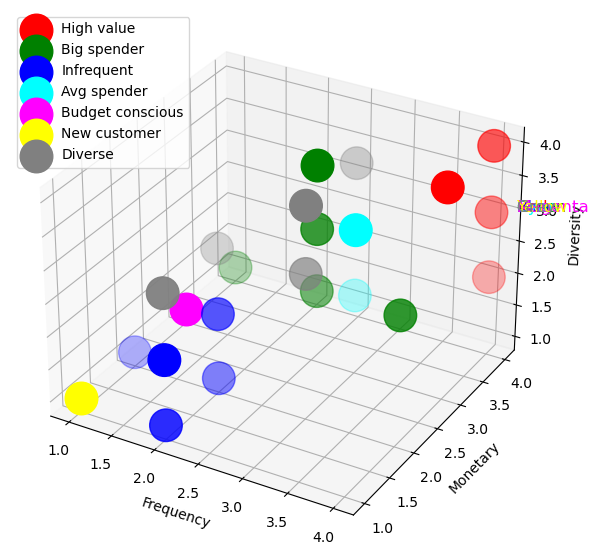

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the clusters and their corresponding scores
cluster1 = [444, 442, 443, 434]
cluster2 = [341, 241, 242, 243, 141]
cluster3 = [211, 212, 222, 221, 121]
cluster4 = [332, 333]
cluster5 = [131]
cluster6 = [111]
cluster7 = [213, 323, 223, 324, 334]

# Create a dictionary to store the clusters and their corresponding scores
clusters = {
    'High value': cluster1,
    'Big spender': cluster2,
    'Infrequent': cluster3,
    'Avg spender': cluster4,
    'Budget conscious': cluster5,
    'New customer': cluster6,
    'Diverse': cluster7
}

# Define a list to store the colors and corresponding labels
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'grey']
color_labels = ['Red', 'Green', 'Blue', 'Cyan', 'Magenta', 'Yellow', 'Grey']

# Initialize the figure
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Loop through each cluster
for i, (cluster_name, scores) in enumerate(clusters.items()):
    # Extract the Frequency, Monetary, and Diversity scores for each customer
    frequency = [int(str(score)[0]) for score in scores]
    monetary = [int(str(score)[1]) for score in scores]
    diversity = [int(str(score)[2]) for score in scores]

    # Plot the points in 3D space
    ax.scatter(frequency, monetary, diversity, c=colors[i], s=550, label=cluster_name)

# Add the color label for each cluster
for i, color_label in enumerate(color_labels):
    ax.text(4.5, 3.5, 3.5, color_label, color=colors[i], fontsize=12)

# Set the axis labels
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Diversity')

# Add a legend
ax.legend()

# Show the plot
plt.show()


## K-Means

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# load your data
df_Kmeans= pd.read_csv('/Users/mustansirmurtazakaj/Desktop/SBPC/Outputs/rfmdc_pre_processed.csv', sep=',')

# select the columns to use for clustering
data = df_Kmeans[["recency", "frequency", "monetary_value", "diversity"]]
# normalize the data
data = (data - data.mean()) / data.std()

# specify the maximum number of clusters to consider
n_clusters_max = 10
# call the function to find the optimal number of clusters
find_optimal_clusters(data, n_clusters_max)
def find_optimal_clusters(data, n_clusters_max):
    sse = []
    for cluster in range(1, n_clusters_max+1):
        kmeans = KMeans(n_clusters=cluster, random_state=0)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    plt.plot(range(1, n_clusters_max+1), sse)
    plt.title("Elbow Method")
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.show()




In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# load your data
df_Kmeans= pd.read_csv('/Users/mustansirmurtazakaj/Desktop/SBPC/Outputs/rfmdc_pre_processed.csv', sep=',')

df_Kmeans

In [ ]:

# Select the columns of 'recency', 'frequency', and 'monetary_value'
X = df_Kmeans[['frequency', 'monetary_value', 'diversity']]

# Fit the k-means algorithm to the scaled data
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X)

# Predict the cluster for each data point
predictions = kmeans.predict(X)

# Add the cluster predictions to the original DataFrame
df_Kmeans['cluster'] = predictions

# Count the number of customers in each cluster
cluster_counts = df_Kmeans['cluster'].value_counts()
print(cluster_counts)

# Plot the number of customers in each cluster
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()


# ____________________________________________________________________________
# Get the cluster labels for each data point
labels = kmeans.labels_

# Initialize the 3D scatter plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points with different colors for each cluster
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink']
for i in range(6):
    cluster = X[labels == i]
    ax.scatter( cluster['frequency'], cluster['monetary_value'], cluster['diversity'], c=colors[i], label='Cluster ' + str(i))

# Add labels and title to the plot
ax.set_zlabel('Diversity')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary Value')
ax.set_title('3D Scatter Plot of Customer Clusters')
plt.legend()

# Show the plot
plt.show()





# Validation of recommender system with purchase in corresponding years

In [ ]:
import pandas as pd
from typing import List
import re

# Load the two CSV files into pandas dataframes
customers_df = pd.read_csv('/Users/mustansirmurtazakaj/Desktop/SBPC/Validations/customers.csv', sep=';')
sales_df = pd.read_csv('/Users/mustansirmurtazakaj/Desktop/SBPC/Validations/sales.csv', sep=';')

# Define a function to clean up product names
def clean_product_name(name: str) -> str:
    name = name.strip()  # Remove any extra spaces before or after the name
    name = re.sub(r'\s+', '', name)  # Remove any whitespace characters within the name
    #name = name.replace("+", "")  # Remove any plus signs from the name
    name = name.replace(".", "")  # Remove any periods from the name
    return name.lower()  # Convert the name to lowercase

# Apply the cleanup function to the product columns in both dataframes
customers_df['recommended_product'] = customers_df['recommended_product'].apply(lambda x: [clean_product_name(item) for item in x.split(',')])
sales_df['purchased_product'] = sales_df['purchased_product'].apply(lambda x: [clean_product_name(item) for item in x.split(',')])


# Group the rows in each Excel sheet by customer ID and concatenate the products for each customer into a list
customers_df = customers_df.groupby('customer_id').agg({'recommended_product': 'sum'}).reset_index()
sales_df = sales_df.groupby('customer_id').agg({'purchased_product': 'sum'}).reset_index()

# Merge the two dataframes on the customer ID column
merged_df = pd.merge(sales_df, customers_df, on='customer_id', how='inner')

# Define a function to calculate the matching score between the recommended and purchased products for a customer
def calculate_matching_score(recommended: list, purchased: list) -> float:
    if not recommended or not purchased:
        return 0
    all_products = recommended + purchased
    unique_products = set(all_products)
    matching_products = set(recommended).intersection(purchased)
    return len(matching_products) / len(unique_products)

# Apply the matching function to each customer in the merged dataframe
matching_scores = merged_df.apply(lambda x: calculate_matching_score(x['recommended_product'], x['purchased_product']), axis=1)

# Add the matching scores to the merged dataframe
merged_df['matching_score'] = matching_scores

# Add labels based on matching scores
def add_matching_labels(score: float) -> str:
    if score == 0:
        return 'No Match'
    elif score >= 0.75:
        return 'High Match'
    elif score >= 0.3:
        return 'Moderate Match'
    else:
        return 'Low Match'

merged_df['matching_label'] = merged_df['matching_score'].apply(add_matching_labels)

# Select only the relevant columns for the final output
#final_df = merged_df[['customer_id', 'purchased_product', 'recommended_product', 'matching_score', 'matching_label']]

# Analyze the matching scores
mean_score = matching_scores.mean()
print('Mean matching score:', mean_score*100, '% (recommended product was bought in the corresponding year by this %)')

# Save the output dataframe to an Excel file
merged_df.to_excel('/Users/mustansirmurtazakaj/Desktop/SBPC/Validations/validation21_22_output(2).xlsx', index=False)

merged_df.describe()
merged_df['matching_label'].describe()

In [133]:
obs_data_bigspender_sf

user_id,item_id
ALTRATEC Automation GmbH,Resale Std. PLUSTRON
ALTRATEC Automation GmbH,APS Analoger Positio
ALTRATEC Automation GmbH,Std. Accessories
ALTRATEC Automation GmbH,PGN+ Parallel Grippe
ASMPT GmbH & Co. KG,Gripping-Rotary-Syst
ASMPT GmbH & Co. KG,Gripping-Rotary-Syst
ASMPT GmbH & Co. KG,Gripping-Rotary-Syst
ASMPT GmbH & Co. KG,Gripping-Rotary-Syst
ASMPT GmbH & Co. KG,Gripping-Rotary-Syst
ASMPT GmbH & Co. KG,Gripping-Rotary-Syst
